In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions

from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons


In [8]:
n_samples = 1000
selected_dataset = 'moons'
epochs = 2001

if selected_dataset == 'moons':
    causal_func = 'linear'  # in {'linear', 'non-linear'}
    noise = 'gaussian'  # in  {'gaussian', laplace, 'cauchy', 'student'}


class RealNVP(nn.Module):
    def __init__(self, nets, nett, masks, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.masks = nn.Parameter(masks, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x * self.masks[i]
            s = self.s[i](x_) * (1 - self.masks[i])
            t = self.t[i](x_) * (1 - self.masks[i])
            x = x_ + (1 - self.masks[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.masks[i] * z
            s = self.s[i](z_) * (1 - self.masks[i])
            t = self.t[i](z_) * (1 - self.masks[i])
            z = (1 - self.masks[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self, x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, batchSize):
        z = self.prior.sample((batchSize, 1))
        logp = self.prior.log_prob(z)
        x = self.g(z)
        return x


def gen_synth_causal_dat(n_samples=100, noise=0.05, causalFunc=causal_func, noise_dist=noise):
    """
    generate causal data where one variable causes another
    Inputs:
        - nObs: number of observations
        - causalFunc: specify causal function
    """

    causalFuncDict = {'linear': lambda x, n: 10 * x + n,
                      'non-linear': lambda x, n: x + (.5) * x * x * x + (n),
                      # 'nueralnet_l1': lambda x, n: sigmoid(sigmoid(np.random.normal(loc=1) * x) + n),
                      # 'mnm': lambda x, n: sigmoid(np.random.normal(loc=1) * x) + .5 * x ** 2
                      #                     + sigmoid(np.random.normal(loc=1) * x) * n
                      }

    # scale divided by np.sqrt(2) to ensure std of 1
    if noise_dist == 'laplace':
        N = np.random.laplace(loc=0, scale=1. / np.sqrt(2), size=(n_samples, 2))
    elif noise_dist == 'gaussian':
        N = np.random.normal(loc=0, scale=1., size=(n_samples, 2))
    elif noise_dist == 'cauchy':
        N = np.random.standard_cauchy(size=(n_samples, 2))
    elif noise_dist == 'student':
        N = np.random.standard_t(df=5, size=(n_samples, 2))
    else:
        raise ValueError(noise_dist)

    X = np.zeros((n_samples, 2))
    X[:, 0] = N[:, 0]
    X[:, 1] = causalFuncDict[causalFunc](X[:, 0], N[:, 1])

    return X, None




iter 0: loss = 2.467
iter 1000: loss = 2.000
iter 2000: loss = 1.989
iter 0: loss = 2.572
iter 1000: loss = 1.274
iter 2000: loss = 1.249
iter 0: loss = 2.551
iter 1000: loss = 0.248
iter 2000: loss = 0.269


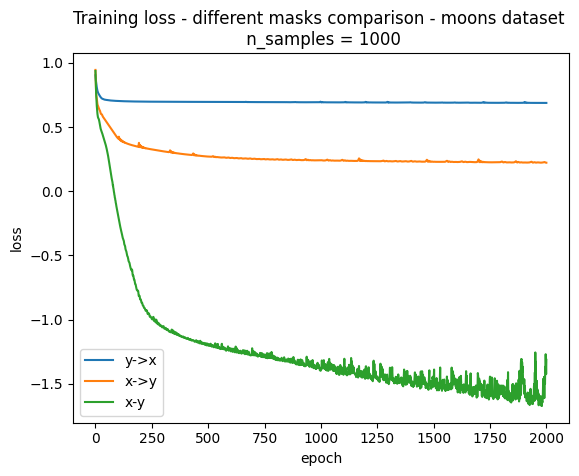

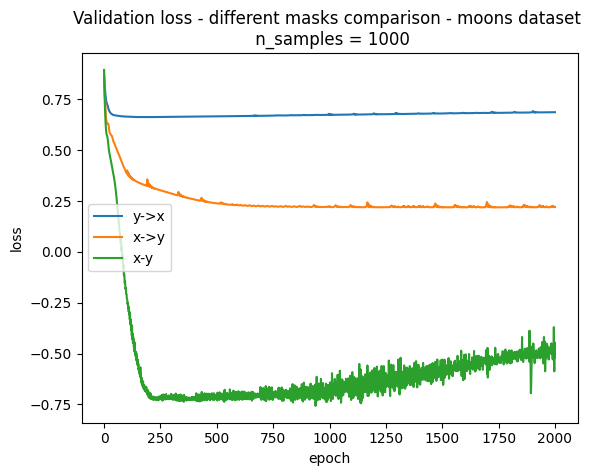

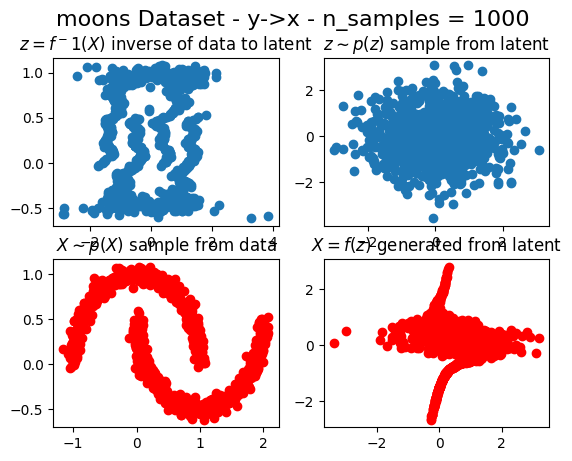

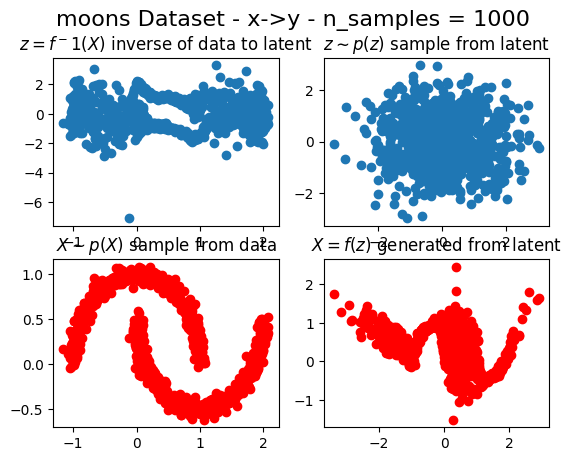

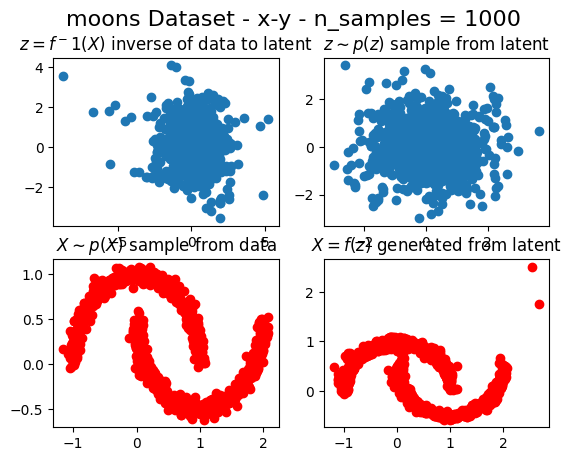

In [9]:
datasets = {'moons': make_moons,
            'causal': gen_synth_causal_dat}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train_flow(dataset=datasets[selected_dataset], mask=[[0, 1], [1, 0]]):
    noisy_dataset = dataset(n_samples, noise=0.05)[0].astype(np.float32)
    train, validation = train_test_split(noisy_dataset, test_size=0.3)

    nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(),
                                 nn.Linear(256, 2),
                                 nn.Tanh())
    nett = lambda: nn.Sequential(nn.Linear(2, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(),
                                 nn.Linear(256, 2))
    masks = torch.from_numpy(np.array(mask * 3).astype(np.float32)).to(device)
    prior = distributions.MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))
    flow = RealNVP(nets, nett, masks, prior).to(device)
    optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad], lr=1e-4)

    train_loss = []
    validation_loss = []

    for t in range(epochs):
        loss = -flow.log_prob(torch.from_numpy(train).to(device)).mean()
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        train_loss.append(loss.item())

        with torch.no_grad():
            validation_loss.append(-flow.log_prob(torch.from_numpy(validation).to(device)).mean().item())

        if t % 1000 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

    return flow, train_loss, validation_loss


mask1 = [[0, 1], [0, 1]]
mask2 = [[1, 0], [1, 0]]
mask3 = [[0, 1], [1, 0]]

masks_dict = {'y->x': mask1,
              'x->y': mask2,
              'x-y': mask3}

# masks_dict = {'x-y': mask3}

train_losses = {}
validation_losses = {}
flows = {}
for mask_name, mask in masks_dict.items():
    flow, train_loss, validation_loss = train_flow(datasets[selected_dataset], mask)
    train_losses[mask_name] = train_loss
    validation_losses[mask_name] = validation_loss
    flows[mask_name] = flow


def plot_losses(train_losses, validation_losses):
    plt.figure()
    for name, loss in train_losses.items():
        plt.plot(np.log(loss), label=name)

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f'Training loss - different masks comparison - {selected_dataset} dataset \n n_samples = {n_samples}')
    plt.legend()

    plt.figure()
    for name, loss in validation_losses.items():
        plt.plot(np.log(loss), label=name)

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title(f'Validation loss - different masks comparison - {selected_dataset} dataset \n n_samples = {n_samples}')
    plt.legend()

    plt.show()


plot_losses(train_losses, validation_losses)

datasets = {'moons': make_moons(n_samples=n_samples, noise=0.05)[0].astype(np.float32),
            'causal': gen_synth_causal_dat(n_samples=n_samples)[0].astype(np.float32)}


def plot_data(dataset, flow, flow_name):
    z = flow.f(torch.from_numpy(dataset).to(device))[0].cpu().detach().numpy()
    fig, _ = plt.subplots(2, 2)
    fig.suptitle(f"{selected_dataset} Dataset - {flow_name} - n_samples = {n_samples}", fontsize=16)

    plt.subplot(221)
    plt.scatter(z[:, 0], z[:, 1])
    plt.title(r'$z = f^-1(X)$ ' + 'inverse of data to latent')

    z = np.random.multivariate_normal(np.zeros(2), np.eye(2), n_samples)
    plt.subplot(222)
    plt.scatter(z[:, 0], z[:, 1])
    plt.title(r'$z \sim p(z)$ ' + 'sample from latent')

    plt.subplot(223)
    plt.scatter(dataset[:, 0], dataset[:, 1], c='r')
    plt.title(r'$X \sim p(X)$ ' + 'sample from data')

    plt.subplot(224)
    x = flow.sample(n_samples).cpu().detach().numpy()
    plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
    plt.title(r'$X = f(z)$ ' + 'generated from latent')


for flow_name, flow in flows.items():
    plot_data(datasets[selected_dataset], flow, flow_name)

plt.show()